# iModulon Characterization: Initial Setup & Characterization from databases

## Setup
This IPython notebook will walk through the steps of characterizing iModulons through semi-automated tools. You will need:
* M and A matrices
* Expression data (e.g. `log_tpm_norm.csv`)
* Gene table and KEGG/GO annotations (Generated in `gene_annotation.ipynb`)
* Sample table, with a column for `project` and `condition`
* TRN file

In [1]:
from os import path
import pandas as pd
import re
from Bio.KEGG import REST
from tqdm.notebook import tqdm

from pymodulon.core import IcaData
from pymodulon.plotting import *


Bad key "text.kerning_factor" on line 4 in
/Users/siddharth/opt/miniconda3/envs/pymodulon/lib/python3.7/site-packages/matplotlib/mpl-data/stylelib/_classic_test_patch.mplstyle.
You probably need to get an updated matplotlibrc file from
https://github.com/matplotlib/matplotlib/blob/v3.1.3/matplotlibrc.template
or from the matplotlib source distribution


In [2]:
# Enter the location of your data here
data_dir = '../data/'

In [3]:
# custom matplotlib stylesheet (uncomment when saving figures)
#plt.style.use('/Users/siddharth/.config/matplotlib/stylelib/figures.mplstyle')

## Check your sample table (i.e. metadata file)
Your metadata file will probably have a lot of columns, most of which you may not care about. Feel free to save a secondary copy of your metadata file with only columns that seem relevant to you. The two most important columns are:
1. `project`
2. `condition`

Make sure that these columns exist in your metadata file

In [4]:
df_metadata = pd.read_csv(path.join(data_dir,'metadata_qc.csv'),index_col=0)
df_metadata[['project','condition']].head()

,project,condition
SRX3467357,FadR,wt_p
SRX3467358,FadR,wt_p
SRX3467359,FadR,ko_p
SRX3467360,FadR,ko_p
SRX3565164,GDGT,75_2.4_log


In [5]:
print(df_metadata.project.notnull().all())
print(df_metadata.condition.notnull().all())

True
True


## Check your TRN

Each row of the TRN file represents a regulatory interaction.  
**Your TRN file must have the following columns:**
1. `regulator` - Name of regulator (`/` or `+` characters will be converted to `;`)
1. `gene_id` - Locus tag of gene being regulated

The following columns are optional, but are helpful to have:
1. `regulator_id` - Locus tag of regulator
1. `gene_name` - Name of gene (can automatically update this using `name2num`)
1. `direction` - Direction of regulation ('+' for activation, '-' for repression, '?' or NaN for unknown)
1. `evidence` - Evidence of regulation (e.g. ChIP-exo, qRT-PCR, SELEX, Motif search)
1. `PMID` - Reference for regulation

You may add any other columns that could help you. TRNs may be saved as either CSV or TSV files. See below for an example:

In [6]:
df_trn = pd.read_csv(path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),sep='\t')
df_trn.head()

,regulator,regulator_id,gene_name,gene_id,old_locus_tag,prokka_locus_tag,synonyms,direction,evidence,PMID,additional_notes
0,BarR,SACI_RS10330,barR,SACI_RS10330,Saci_2136,Sacid_02134,NaN,+,"ChIP-Seq, qRT-PCR",24646198,BarR TF (Lrp/AsnC family transcriptional regul...
1,BarR,SACI_RS10330,Saci_0028,SACI_RS00130,Saci_0028,Sacid_00027,NaN,NaN,ChIP-Seq (weak),27502941,NaN
2,BarR,SACI_RS10330,meaB,SACI_RS00275,Saci_0061,Sacid_00058,NaN,-,ChIP-Seq (weak),27502941,NaN
3,BarR,SACI_RS10330,infB,SACI_RS03305,Saci_0695,Sacid_00675,NaN,NaN,ChIP-Seq (weak),27502941,NaN
4,BarR,SACI_RS10330,Saci_0720,SACI_RS03430,Saci_0720,Sacid_00698,NaN,NaN,ChIP-Seq (weak),27502941,NaN


The `regulator` and `gene_id` must be filled in for each row

In [7]:
print(df_trn.regulator.notnull().all())
print(df_trn.gene_id.notnull().all())

True
True


## Load the data
You're now ready to load your IcaData object!

In [8]:
ica_data = IcaData(M = path.join(data_dir,'ica_runs/80/S.csv'),
                   A = path.join(data_dir,'ica_runs/80/A.csv'),
                   X = path.join(data_dir,'log_tpm_norm.csv'),
                   gene_table = path.join(data_dir,'gene_info_curated_with_operons_and_arCOGS.tsv'),
                   sample_table = path.join(data_dir,'metadata_qc.csv'),
                   trn = path.join(data_dir,'saci_trn_curated_01_01_2021.tsv'),
                   threshold_method = 'kmeans')

In [9]:
pd.read_csv(path.join(data_dir,'gene_info_curated_with_operons_and_arCOGS.tsv'), sep='\t')

,locus_tag,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon
0,SACI_RS00005,cdc6-3,Saci_0001,NaN,NaN,101,1261,+,ORC1-type DNA replication protein 3 (AAA famil...,NaN,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1,Op0
1,SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,NaN,1294,1629,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FP71,NC_007181.1,Op0
2,SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,NaN,1665,2504,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2NAH6,NC_007181.1,Op0
3,SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,NaN,2553,3056,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3HCE5,NC_007181.1,Op1
4,SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,NaN,3049,3768,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FGW8,NC_007181.1,Op1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2291,SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,NaN,2218618,2219355,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport ...",A0A0U2NGD2,NC_007181.1,Op1444
2292,SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,NaN,2219468,2220394,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1,Op1445
2293,SACI_RS11475,cobO,Saci_2373,Sacid_02371,NaN,2220381,2220989,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1,Op1446
2294,SACI_RS11480,Saci_2374,Saci_2374,Sacid_02372,NaN,2221039,2224263,-,S8 family serine peptidase,hypothetical protein,"Posttranslational modification, protein turnov...",A0A0U3FPL4,NC_007181.1,Op1447


In [10]:
ica_data.gene_table

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00005,cdc6-3,Saci_0001,NaN,NaN,101,1261,+,ORC1-type DNA replication protein 3 (AAA famil...,NaN,"Replication, recombination and repair",A0A0U3H3T6,NC_007181.1,Op0,NaN
SACI_RS00010,Saci_0002,Saci_0002,Sacid_00002,NaN,1294,1629,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FP71,NC_007181.1,Op0,NaN
SACI_RS00015,Saci_0003,Saci_0003,Sacid_00003,NaN,1665,2504,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2NAH6,NC_007181.1,Op0,NaN
SACI_RS00020,Saci_0004,Saci_0004,Sacid_00004,NaN,2553,3056,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3HCE5,NC_007181.1,Op1,NaN
SACI_RS00025,Saci_0005,Saci_0005,Sacid_00005,NaN,3049,3768,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FGW8,NC_007181.1,Op1,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
SACI_RS11465,COQ5_5,Saci_2371,Sacid_02369,NaN,2218618,2219355,-,class I SAM-dependent methyltransferase,"2-methoxy-6-polyprenyl-1,4-benzoquinol methyla...","Secondary metabolites biosynthesis, transport ...",A0A0U2NGD2,NC_007181.1,Op1444,NaN
SACI_RS11470,Saci_2372,Saci_2372,Sacid_02370,NaN,2219468,2220394,+,ornithine cyclodeaminase family protein,Delta(1)-pyrroline-2-carboxylate reductase,Amino acid transport and metabolism,A0A0U2Y205,NC_007181.1,Op1445,NaN
SACI_RS11475,cobO,Saci_2373,Sacid_02371,NaN,2220381,2220989,-,"cob(I)yrinic acid a,c-diamide adenosyltransferase",Cobalamin adenosyltransferase,Coenzyme transport and metabolism,UPI000055294E,NC_007181.1,Op1446,NaN
SACI_RS11480,Saci_2374,Saci_2374,Sacid_02372,NaN,2221039,2224263,-,S8 family serine peptidase,hypothetical protein,"Posttranslational modification, protein turnov...",A0A0U3FPL4,NC_007181.1,Op1447,NaN


## Regulatory iModulons (from manually curated TRN file)
Use `compute_trn_enrichment` to automatically check for Regulatory iModulons. The more complete your TRN, the more regulatory iModulons you'll find.


* What is the TRN file?

The TRN file is a manually curated list of regulons from known transciptional regulators or genes known to perform a certain regulatory/functional role with a predicted but currently unidentified transcription factor.


In the case of Sulfolobus acidocaldarius, examples of known regulons include the Archaellum Regulatory Network and the FadR gene clusters

In [11]:
ica_data.compute_trn_enrichment()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
0,11,XylR,3.084629e-11,1.850777e-10,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0
1,12,YtrA,2.737665e-13,1.368833e-12,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0
2,13,LysM,6.324328e-09,6.324328e-09,0.400000,0.571429,0.470588,4.0,7.0,10.0,1.0
3,18,tfb3,1.348608e-36,2.697216e-36,0.937500,0.937500,0.937500,15.0,16.0,16.0,1.0
4,27,ArnR,8.720300e-21,2.616090e-20,1.000000,0.727273,0.842105,8.0,11.0,8.0,1.0
5,27,ArnR1,8.720300e-21,2.616090e-20,1.000000,0.727273,0.842105,8.0,11.0,8.0,1.0
6,27,ArnA,7.760893e-16,1.164134e-15,0.875000,0.466667,0.608696,7.0,15.0,8.0,1.0
7,27,ArnB,7.760893e-16,1.164134e-15,0.875000,0.466667,0.608696,7.0,15.0,8.0,1.0
8,27,biofilm,4.265473e-06,5.118567e-06,0.500000,0.105263,0.173913,4.0,38.0,8.0,1.0
9,29,FadR,1.349778e-37,5.399112e-37,0.760000,0.791667,0.775510,19.0,24.0,25.0,1.0


You can also search for AND/OR combinations of regulators using the `max_regs` argument. Here, we see that iModulon #27 may be regulated by the both ArnR;ArnR1 and ArnA;ArnB.

(This makes sense given that ArnR;ArnR1 are known activators while ArnA;ArnB are known repressors)

In [12]:
# Takes ~20 seconds to run
enrich4 = ica_data.compute_trn_enrichment(max_regs=4, force=True)
set(enrich4.imodulon)

{11, 12, 18, 27, 29}

###### Looking at iModulon 12 enrichements

In [13]:
ica_data.compute_trn_enrichment()[ica_data.compute_trn_enrichment().imodulon == 12]

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
1,12,YtrA,2.737665e-13,1.368833e-12,0.243243,0.5625,0.339623,9.0,16.0,37.0,1.0


In [14]:
enrich4[enrich4.imodulon == 12].head()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
10,12,YtrA/aCPSF2-stat/Saci_2296,3.064045e-15,1.478800e-10,0.324324,0.400000,0.358209,12.0,30.0,37.0,3.0
11,12,YtrA/Saci_2296,1.270774e-14,3.066569e-10,0.270270,0.555556,0.363636,10.0,18.0,37.0,2.0
12,12,YtrA/aCPSF2-stat,6.716541e-14,1.080535e-09,0.297297,0.392857,0.338462,11.0,28.0,37.0,2.0
13,12,YtrA,2.737665e-13,2.642559e-09,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0
14,12,YtrA/aCPSF2-stat/heat-shock/Saci_2296,2.500136e-13,2.642559e-09,0.324324,0.292683,0.307692,12.0,41.0,37.0,4.0


###### Looking at iModulon 27 enrichements (archaellum operon Saci_1171 to Saci_1179)

In [15]:
cond1 = enrich4.imodulon == 27
cond2 = enrich4.n_regs == 4.0
enrich4[cond1 & cond2].head()

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
38,27,ArnR+ArnR1+ArnA+ArnB,9.674248e-19,2.918237e-15,0.875,0.875000,0.875000,7.0,8.0,8.0,4.0
46,27,ArnR/ArnR1/ArnA/ArnB,2.312624e-18,4.464659e-15,1.000,0.444444,0.615385,8.0,18.0,8.0,4.0
52,27,ArnR/ArnR1/ArnA/AbfR1,1.075451e-17,1.572896e-14,1.000,0.380952,0.551724,8.0,21.0,8.0,4.0
57,27,ArnR/ArnR1/ArnB/AbfR1,1.075451e-17,1.572896e-14,1.000,0.380952,0.551724,8.0,21.0,8.0,4.0
58,27,ArnR1/ArnA/ArnB/AbfR1,1.075451e-17,1.572896e-14,1.000,0.380952,0.551724,8.0,21.0,8.0,4.0


###### Looking at iModulon 29 enrichements (FadR gene cluster)

In [16]:
enrich4[enrich4.imodulon == 29]

,imodulon,regulator,pvalue,qvalue,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
106,29,FadR,1.349778e-37,6.514299e-33,0.76,0.791667,0.775510,19.0,24.0,25.0,1.0
107,29,FadR/aCPSF2-log,1.083557e-31,2.614731e-27,0.76,0.500000,0.603175,19.0,38.0,25.0,2.0
108,29,BarR/FadR,1.248024e-29,2.007738e-25,0.76,0.413043,0.535211,19.0,46.0,25.0,2.0
109,29,BarR/FadR/aCPSF2-log,5.928285e-27,7.152772e-23,0.76,0.316667,0.447059,19.0,60.0,25.0,3.0
110,29,FadR/biofilm,8.588204e-27,8.289678e-23,0.76,0.311475,0.441860,19.0,61.0,25.0,2.0
111,29,FadR/aCPSF2-log/biofilm,8.003288e-25,6.437578e-21,0.76,0.253333,0.380000,19.0,75.0,25.0,3.0
112,29,BarR/FadR/biofilm,6.986924e-24,4.817185e-20,0.76,0.228916,0.351852,19.0,83.0,25.0,3.0
113,29,BarR/FadR/aCPSF2-log/biofilm,1.840917e-22,1.110579e-18,0.76,0.195876,0.311475,19.0,97.0,25.0,4.0


Regulator enrichments can be directly saved to the `imodulon_table` using the `save` argument. This saves the enrichment with the lowest q-value to the table. For iModulon #27, it will automatically save `ArnR;ArnR1` as the enrichment, but we want to save `ArnR;ArnR1+ArnA;ArnB`. We can update our enrichments accordingly, using `compute_regulon_enrichment`:

In [17]:
ica_data.compute_regulon_enrichment(11,'XylR',save=True);
ica_data.compute_regulon_enrichment(12,'YtrA',save=True);
ica_data.compute_regulon_enrichment(13,'LysM',save=True)
ica_data.compute_regulon_enrichment(18,'UV-tfb3',save=True);
ica_data.compute_regulon_enrichment(27,'ArnR+ArnR1+ArnA+ArnB',save=True);
ica_data.compute_regulon_enrichment(29,'FadR',save=True);

You can rename iModulons in this jupyter notebook, or you can save the iModulon table as a CSV and edit it in Excel.

In [18]:
reg_entries = ica_data.imodulon_table[ica_data.imodulon_table.regulator.notnull()]
reg_entries

,pvalue,regulator,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs
11,3.084629e-11,XylR,0.212766,0.370370,0.270270,10.0,27.0,47.0,1.0
12,2.737665e-13,YtrA,0.243243,0.562500,0.339623,9.0,16.0,37.0,1.0
13,6.324328e-09,LysM,0.400000,0.571429,0.470588,4.0,7.0,10.0,1.0
18,1.000000e+00,UV-tfb3,0.000000,0.000000,0.000000,0.0,0.0,16.0,1.0
27,9.674248e-19,ArnR+ArnR1+ArnA+ArnB,0.875000,0.875000,0.875000,7.0,8.0,8.0,4.0
29,1.349778e-37,FadR,0.760000,0.791667,0.775510,19.0,24.0,25.0,1.0


In [19]:
ica_data.rename_imodulons(reg_entries.regulator.to_dict())
print(ica_data.imodulon_names[11:30])

['XylR', 'YtrA', 'LysM', 14, 15, 16, 17, 'UV-tfb3', 19, 20, 21, 22, 23, 24, 25, 26, 'ArnR+ArnR1+ArnA+ArnB', 28, 'FadR']


You can also manually rename iModulons with long names

In [20]:
ica_data.rename_imodulons({'ArnR+ArnR1+ArnA+ArnB':'ArnRAB'})

In [21]:
print(ica_data.imodulon_names[27])

ArnRAB


## Functional iModulons

### GO Enrichments

The `GO_annotations.csv` file was created from `gene_annotation.ipynb`.

In [22]:
DF_GO = pd.read_csv(path.join(data_dir,'GO_annotations.csv'),index_col=0)
DF_GO.head()

,gene_id,gene_ontology
0,SACI_RS05325,glycerol kinase activity
1,SACI_RS05325,glycerol metabolic process
2,SACI_RS05525,maltose alpha-glucosidase activity
3,SACI_RS05590,protein binding
4,SACI_RS05600,identical protein binding


In [23]:
DF_GO.gene_id

0     SACI_RS05325
1     SACI_RS05325
2     SACI_RS05525
3     SACI_RS05590
4     SACI_RS05600
5     SACI_RS05610
6     SACI_RS08005
7     SACI_RS08005
8     SACI_RS09830
9     SACI_RS09830
10    SACI_RS10085
11    SACI_RS10085
12    SACI_RS10975
13    SACI_RS10975
14    SACI_RS10975
15    SACI_RS10980
16    SACI_RS10980
17    SACI_RS10980
18    SACI_RS10985
19    SACI_RS10985
20    SACI_RS10985
21    SACI_RS02915
22    SACI_RS00265
23    SACI_RS00265
24    SACI_RS00265
25    SACI_RS00265
26    SACI_RS00925
27    SACI_RS00925
28    SACI_RS00925
29    SACI_RS01090
30    SACI_RS01090
31    SACI_RS02225
32    SACI_RS10090
33    SACI_RS10090
34    SACI_RS00815
35    SACI_RS00815
Name: gene_id, dtype: object

In [24]:
DF_GO_enrich = ica_data.compute_annotation_enrichment(DF_GO,'gene_ontology')

In [25]:
DF_GO_enrich.to_csv(path.join(data_dir,'GO_enrichments.csv'))

### KEGG Enrichments

#### Load KEGG mapping
The `kegg_mapping.csv` file was created from `gene_annotation.ipynb`. This contains KEGG orthologies, pathways, modules, and reactions. Only pathways and modules are relevant to iModulon characterization.

In [26]:
DF_KEGG = pd.read_csv(path.join(data_dir,'kegg_mapping.csv'),index_col=0)
print(DF_KEGG.database.unique())
DF_KEGG.head()

['KEGG_pathway' 'KEGG_module' 'KEGG_reaction']


,gene_id,database,kegg_id
1045,SACI_RS00040,KEGG_pathway,map00760
1046,SACI_RS00040,KEGG_pathway,map01100
1048,SACI_RS00060,KEGG_pathway,map00230
1050,SACI_RS00070,KEGG_pathway,map03410
1055,SACI_RS00085,KEGG_pathway,map00361


In [27]:
kegg_pathways = DF_KEGG[DF_KEGG.database == 'KEGG_pathway']
kegg_modules = DF_KEGG[DF_KEGG.database == 'KEGG_module']

#### Perform enrichment
Uses the `compute_annotation_enrichment` function

In [28]:
DF_pathway_enrich = ica_data.compute_annotation_enrichment(kegg_pathways,'kegg_id')
DF_module_enrich = ica_data.compute_annotation_enrichment(kegg_modules,'kegg_id')

In [29]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0


In [30]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size
0,4,M00125,5.693334e-06,9.678668e-04,0.333333,1.000000,0.500000,2.0,2.0,6.0
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0


#### Convert KEGG IDs to human-readable names

In [31]:
for idx,key in tqdm(DF_pathway_enrich.kegg_id.items(),total=len(DF_pathway_enrich)):
    text = REST.kegg_find('pathway',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_pathway_enrich.loc[idx,'pathway_name'] = name
    except AttributeError:
        DF_pathway_enrich.loc[idx,'pathway_name'] = None
    
for idx,key in tqdm(DF_module_enrich.kegg_id.items(),total=len(DF_module_enrich)):
    text = REST.kegg_find('module',key).read()
    try:
        name = re.search('\t(.*)\n',text).group(1)
        DF_module_enrich.loc[idx,'module_name'] = name
    except AttributeError:
        DF_module_enrich.loc[idx,'module_name'] = None

  0%|          | 0/66 [00:00<?, ?it/s]

  0%|          | 0/48 [00:00<?, ?it/s]

In [32]:
DF_pathway_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
0,4,map00740,8.500350e-05,1.674569e-02,0.333333,0.333333,0.333333,2.0,6.0,6.0,Riboflavin metabolism
1,7,map00720,1.947367e-11,3.836313e-09,0.529412,0.169811,0.257143,9.0,53.0,17.0,Carbon fixation pathways in prokaryotes
2,7,map01120,1.296231e-08,1.026232e-06,0.588235,0.067114,0.120482,10.0,149.0,17.0,Microbial metabolism in diverse environments
3,7,map01200,1.562789e-08,1.026232e-06,0.529412,0.082569,0.142857,9.0,109.0,17.0,Carbon metabolism
4,7,map00261,7.608847e-04,2.997886e-02,0.117647,0.333333,0.173913,2.0,6.0,17.0,Monobactam biosynthesis


In [33]:
DF_module_enrich.head()

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
0,4,M00125,5.693334e-06,9.678668e-04,0.333333,1.000000,0.500000,2.0,2.0,6.0,"Riboflavin biosynthesis, plants and bacteria, ..."
1,7,M00375,3.286981e-14,5.587867e-12,0.529412,0.321429,0.400000,9.0,28.0,17.0,Hydroxypropionate-hydroxybutylate cycle
2,7,M00374,1.771895e-06,1.506111e-04,0.294118,0.161290,0.208333,5.0,31.0,17.0,Dicarboxylate-hydroxybutyrate cycle
3,7,M00033,3.070233e-04,1.237299e-02,0.117647,0.500000,0.190476,2.0,4.0,17.0,"Ectoine biosynthesis, aspartate => ectoine"
4,7,M00525,5.094759e-04,1.237299e-02,0.117647,0.400000,0.181818,2.0,5.0,17.0,"Lysine biosynthesis, acetyl-DAP pathway, aspar..."


#### Save files

In [34]:
DF_pathway_enrich.to_csv(path.join(data_dir,'kegg_pathway_enrichments.csv'))
DF_module_enrich.to_csv(path.join(data_dir,'kegg_module_enrichments.csv'))

In [35]:
# Custom function (will be useful for characterizing iModulons)
def get_kegg_enrichments(imodulon, kegg_type):
    if kegg_type == 'pathway':
        df = DF_pathway_enrich
    elif kegg_type == 'module':
        df = DF_module_enrich
    else:
        raise ValueError('kegg_type must be either "pathway" or "module"')
    
    cond = df['imodulon'] == imodulon
    return df[cond].dropna()

## Check for single gene iModulons

In [36]:
sg_imods = ica_data.find_single_gene_imodulons(save=True)

In [37]:
for i,mod in enumerate(sg_imods):
    ica_data.rename_imodulons({mod:'single_gene_'+str(i+1)})

In [38]:
for name in ica_data.imodulon_names:
    if not isinstance(name, int) and 'single_gene' in name:
        print(name)

single_gene_1
single_gene_2
single_gene_3
single_gene_4
single_gene_5
single_gene_6


## Compare against published iModulons
We can use the `compare_ica` function to compare iModulons across different organisms. To do so, you must provide the path to a Bidirection Best Hist CSV between your two organisms of interest.

A Github repository containing many BBH CSV's can be found at the following
link: https://github.com/SBRG/modulome_compare_data/tree/master/bbh_csv

You can also provide a path to your own BBH file, as long as it contains the
columns "**gene**" and "**target**"

In [39]:
from pymodulon.compare import *
from pymodulon.io import *

In [40]:
ecoli_data = load_json_model('../example_data/example.json')

In [41]:
dots,links = compare_ica(ecoli_data.M, ica_data.M, cutoff=0.25,
                         ortho_file = '../example_data/example_bbh.csv')
dots

[('GlpR', 'XylR', 0.30674307276839063),
 ('GlpR', 39, 0.26593488292286765),
 ('ArgR', 19, 0.29082354278038275),
 ('OxyR', 2, 0.32441595386469396),
 ('PurR-1', 10, 0.6533523554798282),
 ('PurR-2', 20, 0.27509488805058346),
 ('translation', 23, 0.25979645228799747),
 ('Lrp', 31, 0.272555233836214),
 ('CysB', 23, 0.6176360657152684),
 ('NtrC+RpoN', 26, 0.25292366658333265),
 ('NtrC+RpoN', 38, 0.39070676888961775),
 ('Fur-2', 25, 0.4045954149766546),
 ('Nac', 20, 0.2630541468521022),
 ('FadR/IclR', 'FadR', 0.39750691518554093),
 ('crp-KO', 'XylR', 0.259091645901679)]

In the above plot, the top named iModulons are from *E. coli* and the bottom iModulons are from our target organism. Note that the two FadR iModulons are linked together. This `links` variable contains all pairs of iModulons that are linked together

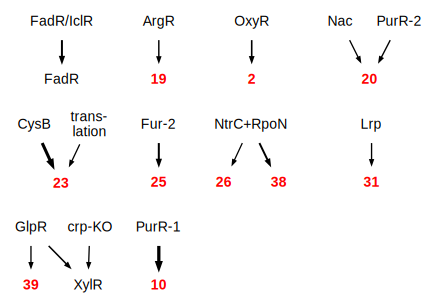

In [42]:
links

In [43]:
ica_data.imodulon_table['ecoli_ortholog'] = np.nan

for ecoli_mod,target_mod,dist in dots:
    try:
        xx = int(target_mod)
    except ValueError:
        xx = target_mod
    finally:
        ica_data.imodulon_table.loc[xx,'ecoli_ortholog'] = ecoli_mod

# Manually add complex orthologs
ica_data.imodulon_table.loc['XylR', 'ecoli_ortholog'] = 'GlpR, crp-KO'
ica_data.imodulon_table.loc[23, 'ecoli_ortholog'] = 'CysB, translation'

ica_data.imodulon_table.loc[[2, 10, 'XylR', 19, 20, 23, 25, 26, 'FadR', 38, 39]]

,pvalue,regulator,precision,recall,f1score,TP,regulon_size,imodulon_size,n_regs,single_gene,ecoli_ortholog
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,OxyR
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,PurR-1
XylR,3.084629e-11,XylR,0.212766,0.370370,0.27027,10.0,27.0,47.0,1.0,NaN,"GlpR, crp-KO"
19,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,ArgR
20,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Nac
23,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"CysB, translation"
25,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Fur-2
26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NtrC+RpoN
FadR,1.349778e-37,FadR,0.760000,0.791667,0.77551,19.0,24.0,25.0,1.0,NaN,FadR/IclR
38,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NtrC+RpoN


### Visualize linked iModulons

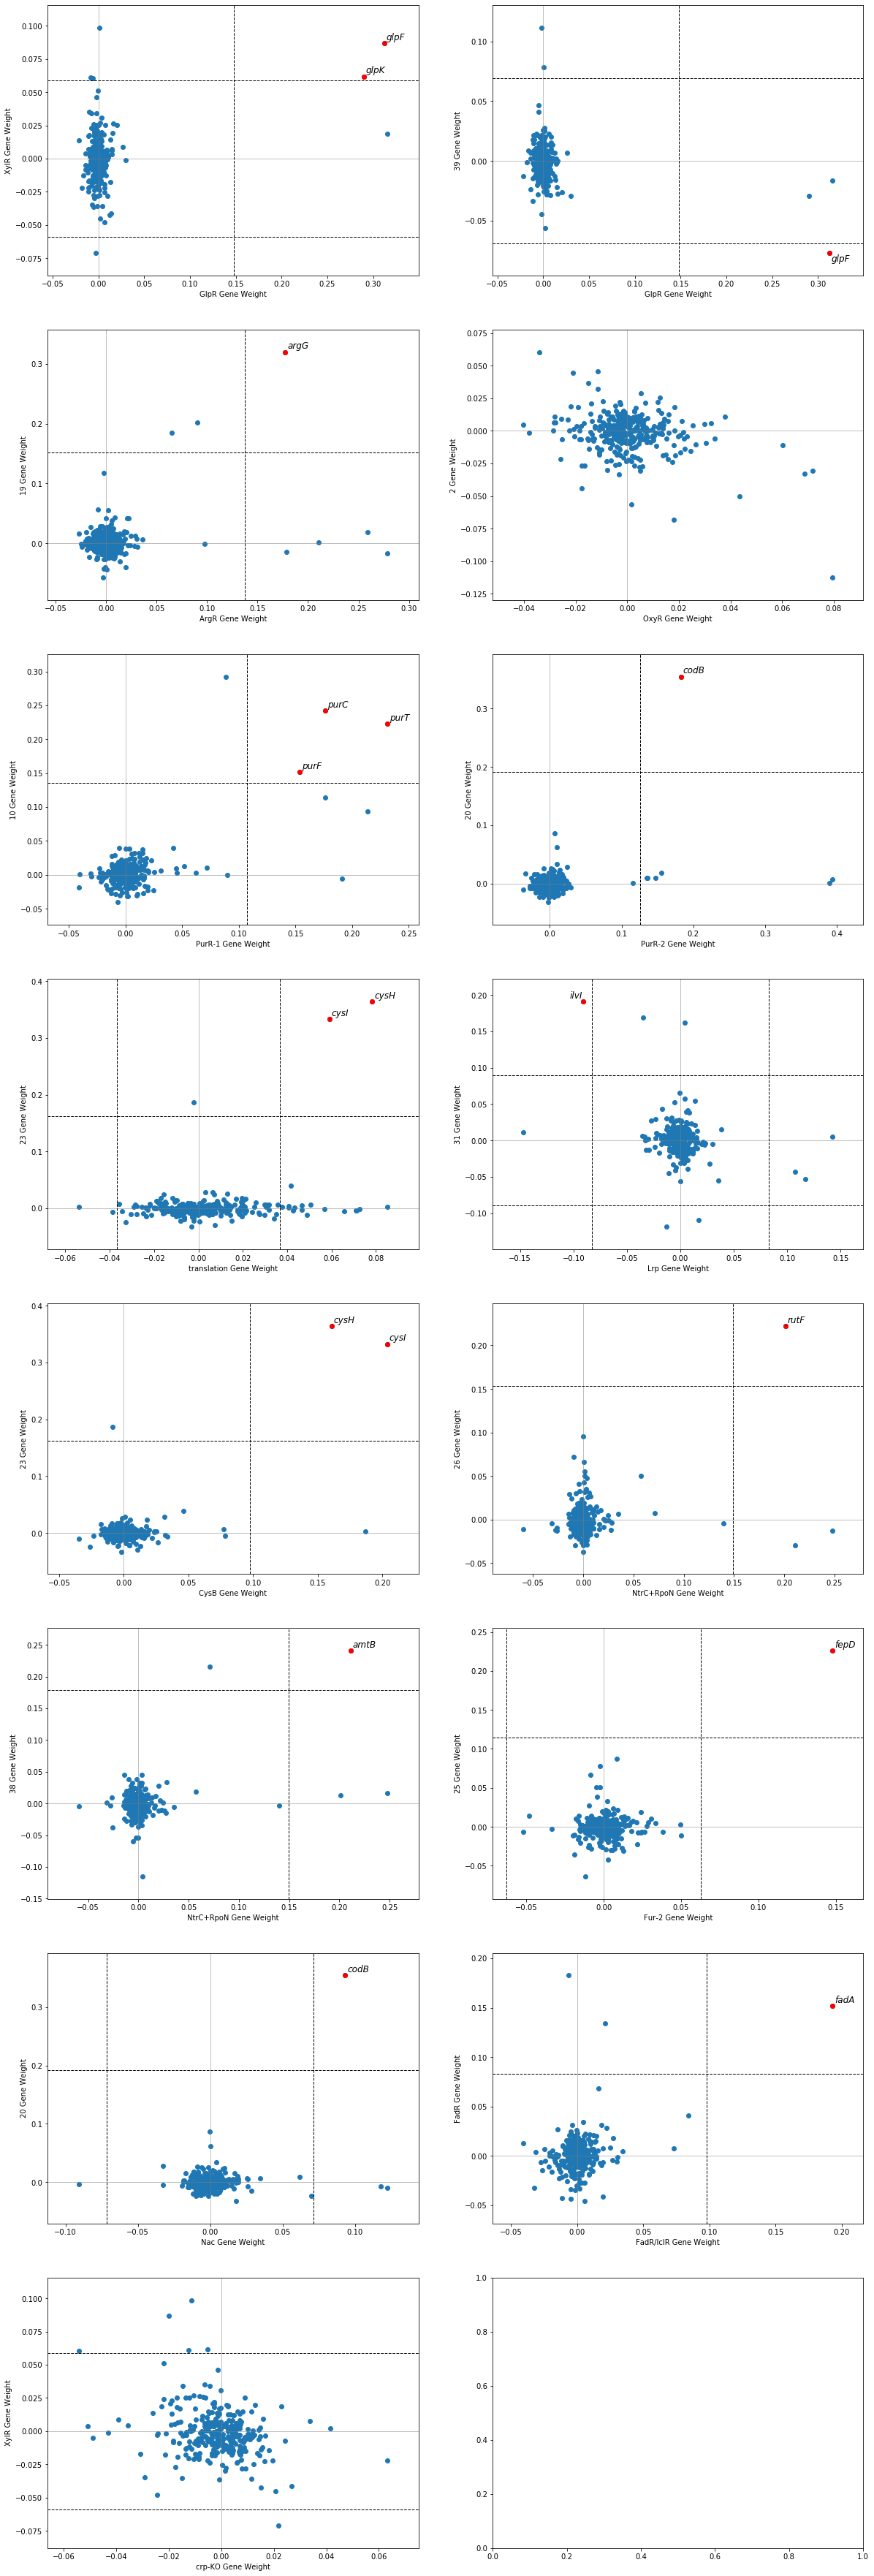

In [44]:
# Number of Rows:
num_rows = int(np.ceil(len(dots) / 2))

# Plot figures
fig, axs = plt.subplots(nrows=num_rows, ncols=2, figsize=(20, 8*num_rows))

counter = 0
for ecoli_mod,saci_mod,_ in dots:
    
    if counter % 2 == 0:
        r = int(counter / 2)
        c = 0
    else:
        r = int((counter - 1) / 2)
        c = 1
    
    compare_gene_weights(ica_data = ecoli_data,imodulon1=ecoli_mod,
                         ica_data2 = ica_data,imodulon2=saci_mod,
                         ortho_file ='../example_data/example_bbh.csv',
                         ax=axs[r, c])
    
    counter += 1

---

## Characterize Specified iModulons

### Known iModulons

These iModulons are fully characterized and match what is known in literature. In particular, ArnRAB, FadR, and FadR-KO iModulons can be used as literature-validation iModulons.

#### iModulon 27: ArnRAB

**The Archaellum Regulatory Network iModulon:**

Contains the Arn operon genes (Saci_1172 to Saci_1179). This operon, activated by ArnR/ArnR1 and repressed by ArnA/ArnB, is necessary for the generation of archaella, bacterial type-IV pili that function as flagella for this organism.

This iModulon differs from its regulons as it does not contain the transcription factors ArnR, ArnR1, ArnS, ArnA, ArnB and their phosphorylators ArnC, ArnD, Saci_pp2a, Saci_1208, and Saci_1209. This is partly expecter, however, as these TFs have been hypothesized to be regulated by something else (potentially UspA_Sa).

As expected from literature, this iModulon's activity increases during nutrient limitation conditions and is generally higher in the stationary phase vs log phase as archaella are used by Saci to move around and find food in their environment.

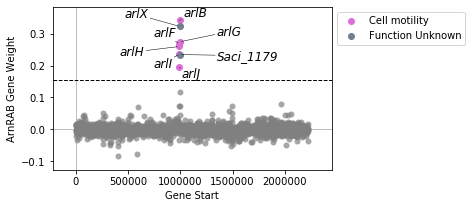

In [45]:
fig, ax = plt.subplots(figsize=(5, 3))

ax = plot_gene_weights(ica_data, 'ArnRAB', ax=ax)

#plt.savefig('../figures/ArnRAB_gene_weights.pdf', transparent=True)

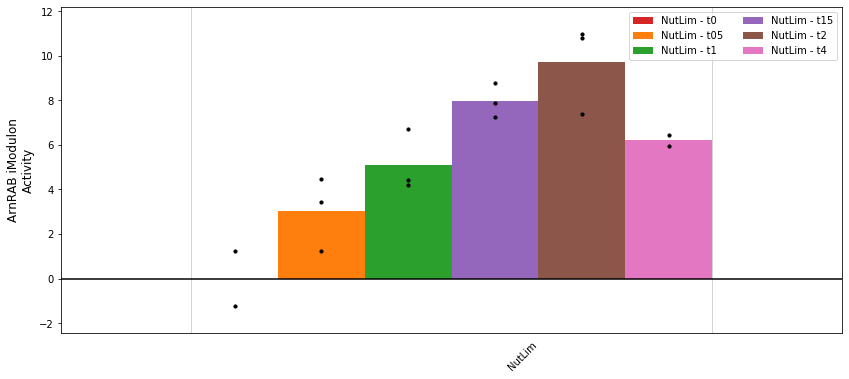

In [46]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'ArnRAB', projects='NutLim', highlight='NutLim', ax=ax)

#plt.savefig('../figures/ArnRAB_actv.pdf')

In [47]:
cond = ica_data.gene_table['gene_name'] == 'arnB'
ica_data.gene_table.loc[cond]

,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS05770,arnB,Saci_1211,Sacid_01188,NaN,1029690,1030832,+,VWA domain-containing protein,hypothetical protein,General Function Prediction Only,A0A0U3GUB2,NC_007181.1,Op668,"ArnA,ArnB"


#### iModulon 29: FadR  [E coli Ortholog: FadR/IclR]

**Fatty Acid Degradation Repressor iModulon**

Contains the FadR gene cluster, as well as a few other acyl-CoA ligases. Notably does not contain the fadR gene itself. FadR is a repressor that inhibits fatty acid breakdown genes from activating unless there is a high concentration of medium- to long-chain acyl-CoA in the cytosol.

This iModulon also does not contains 13 genes found in the regulon, many being hyrolases and short-chain-dehydrogenase oxidoreductases. This suggests that short-chain fatty acids may be regulated by another transcription factor. Additionally, the iModulon contains 6 genes that are not in the regulon, all of which are hypothetical proteins with little known about them.

The FadR iModulon has its highest activity in fadR deletion strains in both the `Chrom` and `FadR` projects, with the `NutLim` project being fairly high as well. This suggests that the iModulon is upregulated when the FadR gene cluster is actively expressed (i.e. high conc of med- and long-chain acyl-CoA or during nutrient limitation when fatty acids must be broken down as an alternative energy source).

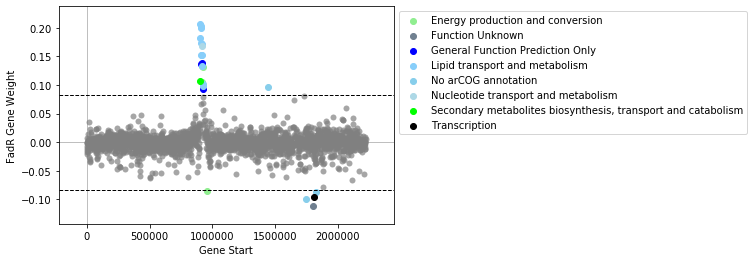

In [48]:
ax = plot_gene_weights(ica_data, 'FadR')

#plt.savefig('../figures/FadR_gene_weights.pdf')

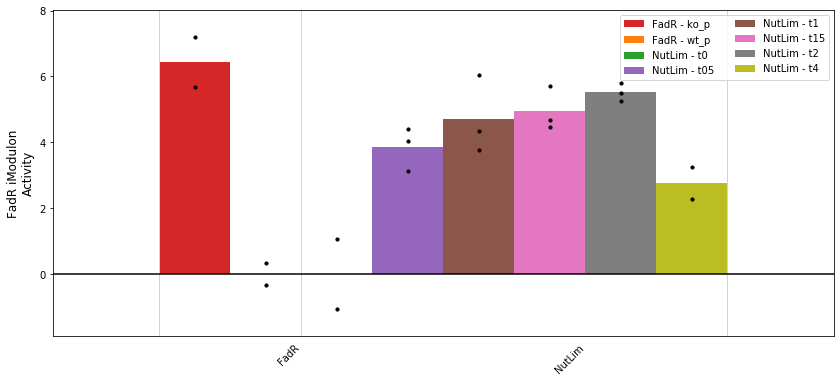

In [49]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'FadR', projects=['FadR', 'NutLim'], highlight=['Chrom', 'FadR', 'NutLim'], ax=ax)

#plt.savefig('../figures/FadR_actv.pdf')

#### iModulon 24: FadR-KO iModulon (formerly single_gene_3)

**FadR TF iModulon**

Contains only 1 gene, __Saci_1107__, which codes for FadR

The activity of this iModulon is similar to the FadR iModulon, with the notable exception of the FadR-KO experiment having a substantially negative activity.

In [50]:
ica_data.rename_imodulons({'single_gene_3':'FadR-KO'})

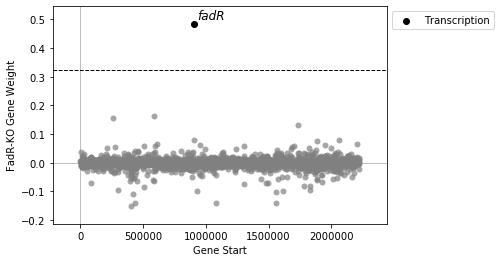

In [51]:
plot_gene_weights(ica_data, 'FadR-KO')

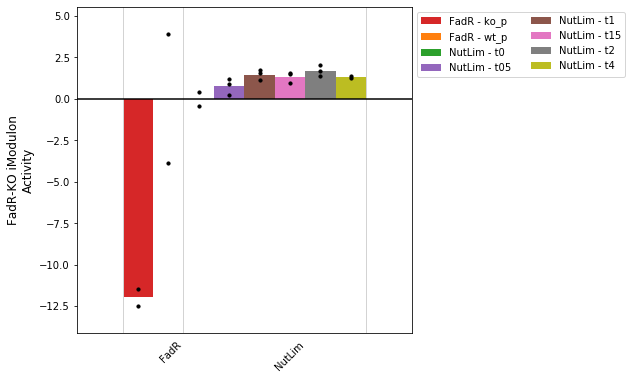

In [52]:
fig, ax = plt.subplots(figsize=(6, 6))
plot_activities(ica_data, 'FadR-KO', projects=['FadR', 'NutLim'], highlight=['FadR', 'NutLim'], ax=ax)

### Regulon-matching iModulons

These iModulons match closely with a regulon from the manually curated TRN file (based on known literature) and were chosen via trn enrichment (See Regulatory-iModulons section)

#### iModulon 11: XylR-matching iModulon [E. coli orthologs: GlpR, crp-KO]

#### Putative Composite iModulon [ Glyerol Uptake (GlpR-like) + Pentose Uptake (XylR) +  ETC (SoxEFGHIM) ]

#### We call this iModulon XylR-SoxM due to its 2 most defined members, 
#### inclusion of much of the XylR regulon as well as inclusion of the entire SoxM gene cluster (SoxEFGIM)

3 options for regulators

1. XylR only (global regulator not just for pentose uptake but for central-carbon overall
2. XylR + others (multiple regulators)
3. Master regulator (which toggles XylR too)

In [53]:
get_kegg_enrichments('XylR', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
17,XylR,map00310,0.000873,0.038839,0.063830,0.300000,0.105263,3.0,10.0,47.0,Lysine degradation
18,XylR,map00380,0.001183,0.038839,0.063830,0.272727,0.103448,3.0,11.0,47.0,Tryptophan metabolism
19,XylR,map00620,0.001113,0.038839,0.106383,0.125000,0.114943,5.0,40.0,47.0,Pyruvate metabolism
20,XylR,map00640,0.000385,0.038839,0.106383,0.156250,0.126582,5.0,32.0,47.0,Propanoate metabolism
21,XylR,map00720,0.000589,0.038839,0.127660,0.113208,0.120000,6.0,53.0,47.0,Carbon fixation pathways in prokaryotes
22,XylR,map00362,0.001555,0.043752,0.063830,0.250000,0.101695,3.0,12.0,47.0,Benzoate degradation
23,XylR,map02020,0.003079,0.075828,0.063830,0.200000,0.096774,3.0,15.0,47.0,Two-component system
24,XylR,map00900,0.003736,0.081772,0.063830,0.187500,0.095238,3.0,16.0,47.0,Terpenoid backbone biosynthesis


In [54]:
get_kegg_enrichments('XylR', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
14,XylR,M00088,0.000873,0.049459,0.063830,0.300000,0.105263,3.0,10.0,47.0,"Ketone body biosynthesis, acetyl-CoA => acetoa..."
15,XylR,M00373,0.000873,0.049459,0.063830,0.300000,0.105263,3.0,10.0,47.0,Ethylmalonyl pathway
16,XylR,M00416,0.000410,0.049459,0.042553,1.000000,0.081633,2.0,2.0,47.0,Cytochrome aa3-600 menaquinol oxidase
17,XylR,M00155,0.001215,0.051629,0.042553,0.666667,0.080000,2.0,3.0,47.0,"Cytochrome c oxidase, prokaryotes"
18,XylR,M00095,0.001992,0.062403,0.063830,0.230769,0.100000,3.0,13.0,47.0,"C5 isoprenoid biosynthesis, mevalonate pathway"
19,XylR,M00375,0.002202,0.062403,0.085106,0.142857,0.106667,4.0,28.0,47.0,Hydroxypropionate-hydroxybutylate cycle
20,XylR,M00374,0.003236,0.078580,0.085106,0.129032,0.102564,4.0,31.0,47.0,Dicarboxylate-hydroxybutyrate cycle


In [55]:
ica_data.rename_imodulons({'XylR': 'XylR-SoxM'})

In [56]:
# Intersection of TRN and XylR-SoxM iModulon shows overlap with all but 1 gene (parA, BarR regulon)
set(ica_data.trn.gene_name).intersection(
    set(ica_data.view_imodulon('XylR-SoxM').gene_name))

{'Saci_1147',
 'Saci_1148',
 'Saci_1760',
 'Saci_2230',
 'Saci_2231',
 'Saci_2232',
 'Saci_2233',
 'acsA_5',
 'parA',
 'trxA',
 'xylF'}

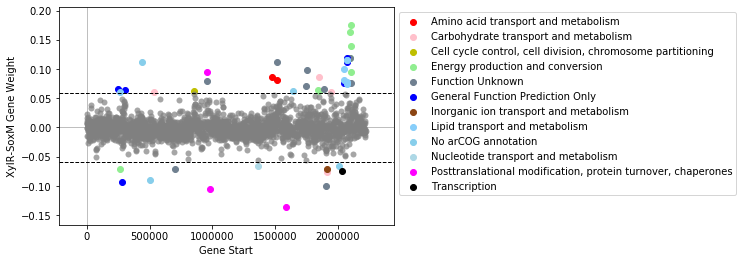

In [57]:
plot_gene_weights(ica_data, 'XylR-SoxM')

plt.savefig('../figures/XylR_gene_weights.pdf')

In [58]:
ica_data.view_imodulon('XylR-SoxM').sort_values(by='gene_weight', ascending=False)

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS10935,0.174414,soxF,Saci_2261,Sacid_02262,aioB,2102564,2103316,-,Rieske 2Fe-2S domain-containing protein,Arsenite oxidase subunit AioB,Energy production and conversion,F2Z628,NC_007181.1,Op1373,NaN
SACI_RS10930,0.163053,soxG,Saci_2260,Sacid_02261,"fbcH, soxC_2",2101038,2102558,-,cytochrome a-587,Cytochrome b/c1,Energy production and conversion,A0A0U2NHR0,NC_007181.1,Op1373,"hypotonic-all,hypotonic-all-acid"
SACI_RS10940,0.139025,soxE,Saci_2262,Sacid_02263,soxE_2,2103461,2104060,+,sulfocyanin (blue copper),hypothetical protein,Energy production and conversion,A0A0U2NAM5,NC_007181.1,Op1374,NaN
SACI_RS10920,0.118762,soxI,Saci_2258,Sacid_02259,NaN,2100162,2100608,-,hypothetical protein,hypothetical protein,Function Unknown,F2Z5W8,NC_007181.1,Op1373,NaN
SACI_RS10925,0.118676,soxH,Saci_2259,Sacid_02260,ctaC,2100611,2101051,-,cbb3-type cytochrome c oxidase subunit II,Cytochrome c oxidase subunit 2,Energy production and conversion,F2Z6G7,NC_007181.1,Op1373,NaN
SACI_RS10785,0.118350,Saci_2231,Saci_2231,Sacid_02232,NaN,2073571,2074068,-,Predicted DNA-binding protein containing a Zn-...,hypothetical protein,General Function Prediction Only,A0A0U3GN05,NC_007181.1,Op1355,"YtrA,XylR"
SACI_RS10790,0.115935,Saci_2232,Saci_2232,Sacid_02233,NaN,2074080,2075258,-,conserved archaeal acetyl-CoA acetyltransferase,hypothetical protein,Lipid transport and metabolism,A0A0U3HCP2,NC_007181.1,Op1355,"YtrA,XylR"
SACI_RS10795,0.115060,Saci_2233,Saci_2233,Sacid_02234,NaN,2075255,2076403,-,Acetyl-CoA acetyltransferase,hypothetical protein,Lipid transport and metabolism,A0A0U3GXD6,NC_007181.1,Op1355,"YtrA,XylR"
SACI_RS08385,0.112419,Saci_1754,Saci_1754,Sacid_01719,NaN,1512195,1512635,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3H5I1,NC_007181.1,Op990,NaN
SACI_RS11800,0.111932,SACI_RS11800,NaN,NaN,NaN,442246,442317,-,hypothetical protein,NaN,No arCOG annotation,NaN,NC_007181.1,Op310,NaN


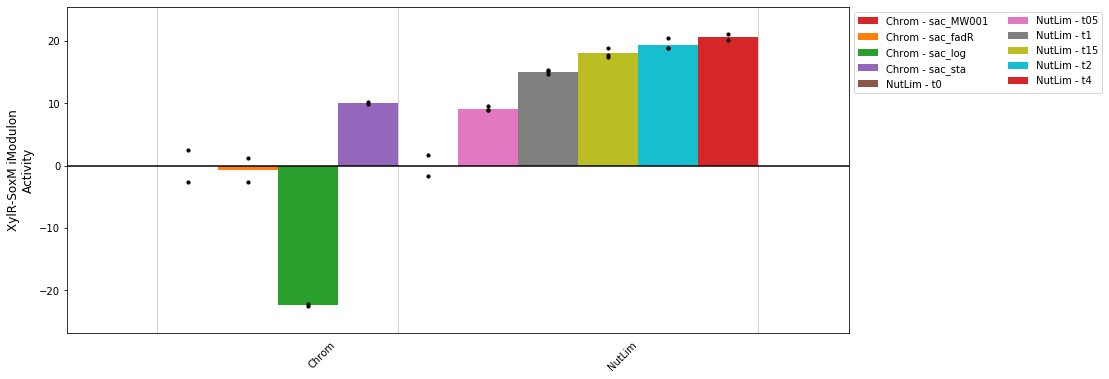

In [59]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'XylR-SoxM',
                projects=['Chrom', 'NutLim'],
                highlight=['Chrom', 'NutLim'],
                ax=ax)

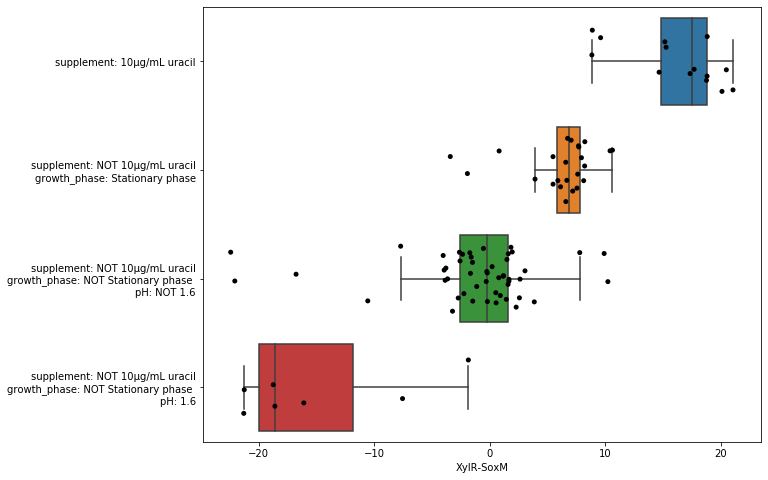

In [60]:
fig, ax = plt.subplots(figsize=(10, 8))
metadata_boxplot(ica_data, 'XylR-SoxM', n_boxes=4, ax=ax)

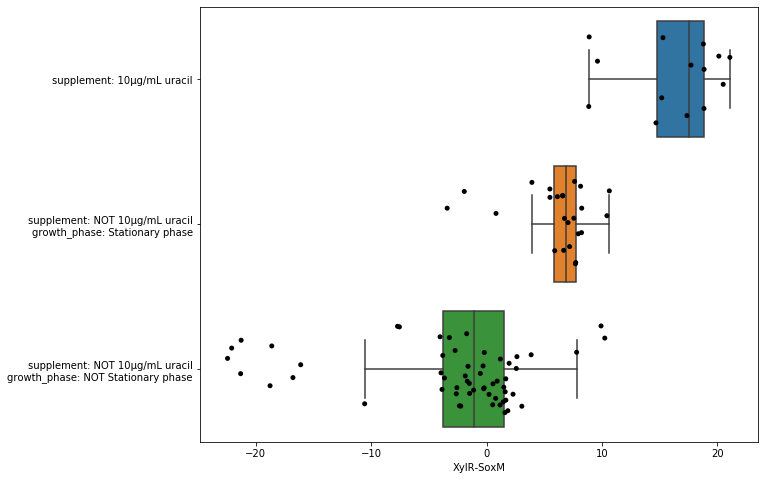

In [61]:
fig, ax = plt.subplots(figsize=(10, 8))
metadata_boxplot(ica_data, 'XylR-SoxM', n_boxes=3, ax=ax)

In [62]:
from matplotlib_venn import venn3

In [63]:
XylR_SoxM = set(ica_data.view_imodulon('XylR-SoxM').index)

XylR = set(ica_data.trn.loc[ica_data.trn.regulator=='XylR'].gene_id.values)

SoxM = set(['SACI_RS10920', 'SACI_RS10925', 'SACI_RS10930', 'SACI_RS10935', 'SACI_RS10940', 'SACI_RS10945'])

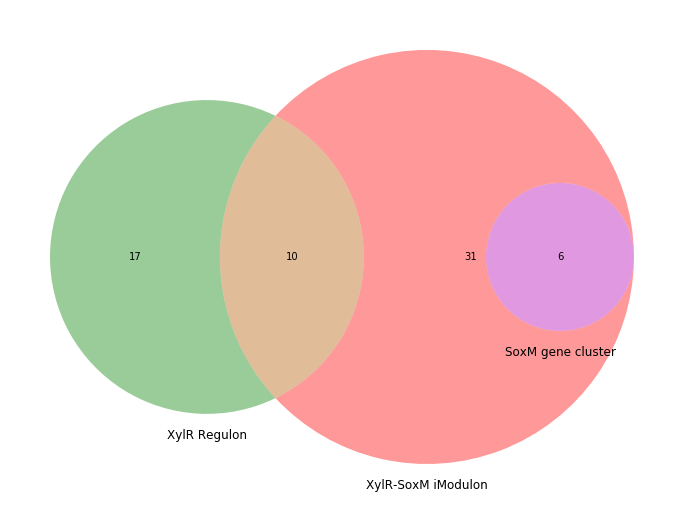

In [64]:
fig, ax = plt.subplots(figsize=(12, 12))

venn3(
    subsets=[XylR_SoxM, XylR, SoxM],
    set_labels=('XylR-SoxM iModulon', 'XylR Regulon', 'SoxM gene cluster'),
    ax=ax
)

#plt.savefig('../figures/XylR_venn.pdf')

#### iModulon 12: YtrA iModulon

#### Putative GTP/G-Protein-Coupled-Receptor / Metal Uptake iModulon 

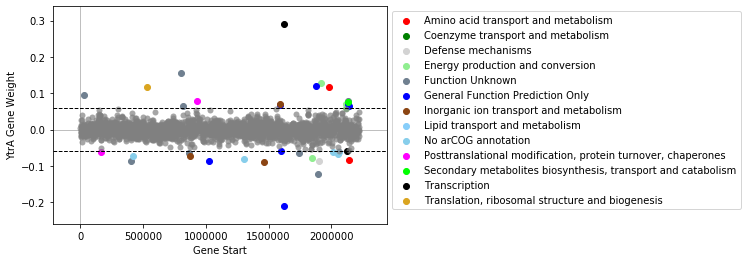

In [65]:
plot_gene_weights(ica_data, 'YtrA')

In [66]:
ica_data.view_imodulon('YtrA')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS00195,0.094740,IMPDH_1,Saci_0044,Sacid_00042,NaN,29614,30108,+,CBS domain-containing protein,Inosine-5'-monophosphate dehydrogenase,Function Unknown,A0A0U3GVE4,NC_007181.1,Op23,YtrA
SACI_RS00955,-0.061389,Saci_0198,Saci_0198,Sacid_00192,NaN,160314,162212,+,thioredoxin domain-containing protein,hypothetical protein,"Posttranslational modification, protein turnov...",A0A0U3FY45,NC_007181.1,Op104,NaN
SACI_RS02340,-0.087781,Saci_0484,Saci_0484,Sacid_00477,NaN,404875,405324,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U2X0E9,NC_007181.1,Op275,YtrA
SACI_RS02440,-0.073582,Saci_0506,Saci_0506,Sacid_00500,NaN,419872,420159,-,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U3FFQ9,NC_007181.1,Op291,NaN
SACI_RS03165,0.117220,Saci_0664,Saci_0664,Sacid_00646,NaN,526525,526800,-,hypothetical protein,hypothetical protein,"Translation, ribosomal structure and biogenesis",A0A0U3FMW0,NC_007181.1,Op356,NaN
SACI_RS04795,0.156636,Saci_1004,Saci_1004,Sacid_00978,NaN,805226,805438,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FLQ2,NC_007181.1,Op526,NaN
SACI_RS04865,0.063848,Saci_1019,Saci_1019,Sacid_00992,NaN,818942,819370,+,small multi-drug export protein,hypothetical protein,Function Unknown,A0A0U2XZL5,NC_007181.1,Op535,NaN
SACI_RS05085,-0.063764,Saci_1065,Saci_1065,Sacid_01041,NaN,869143,869940,+,ABC transporter permease,hypothetical protein,Function Unknown,A0A0U3GJ67,NC_007181.1,Op567,NaN
SACI_RS05090,-0.072732,btuD_6,Saci_1066,Sacid_01042,NaN,869942,870712,+,ATP-binding cassette domain-containing protein,Vitamin B12 import ATP-binding protein BtuD,Inorganic ion transport and metabolism,A0A0U3GK01,NC_007181.1,Op567,NaN
SACI_RS05365,0.078384,bcp_1,Saci_1125,Sacid_01101,NaN,929275,929751,-,peroxiredoxin,Putative peroxiredoxin,"Posttranslational modification, protein turnov...",A0A0U3GSS4,NC_007181.1,Op611,FadR


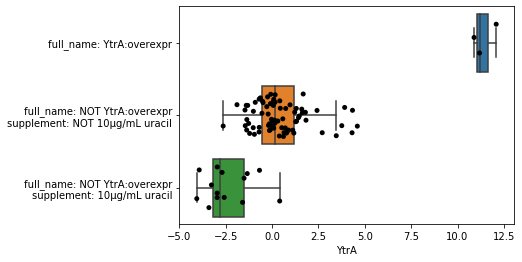

In [67]:
metadata_boxplot(ica_data, 'YtrA')

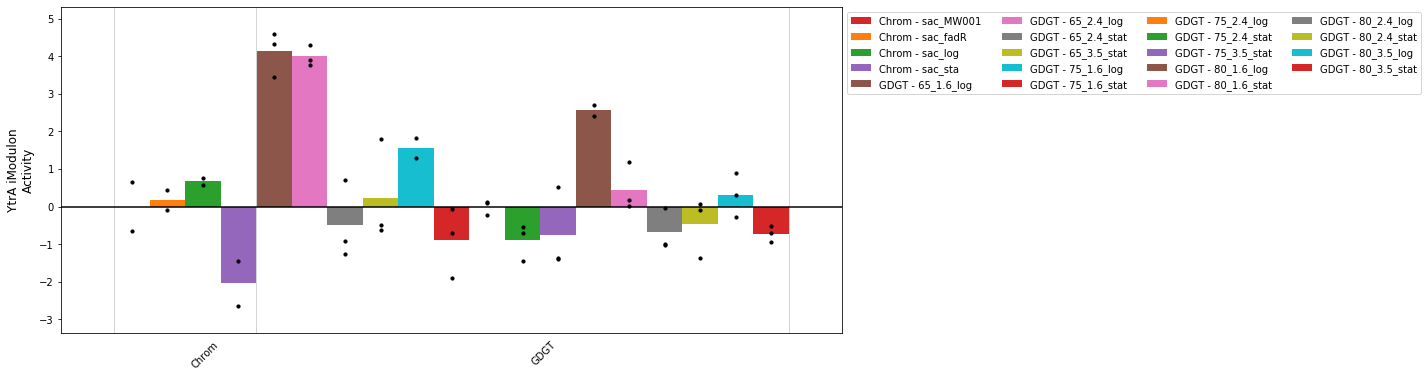

In [68]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'YtrA',
                projects=['Chrom', 'GDGT'],
                highlight=['Chrom', 'GDGT'],
                ax=ax)

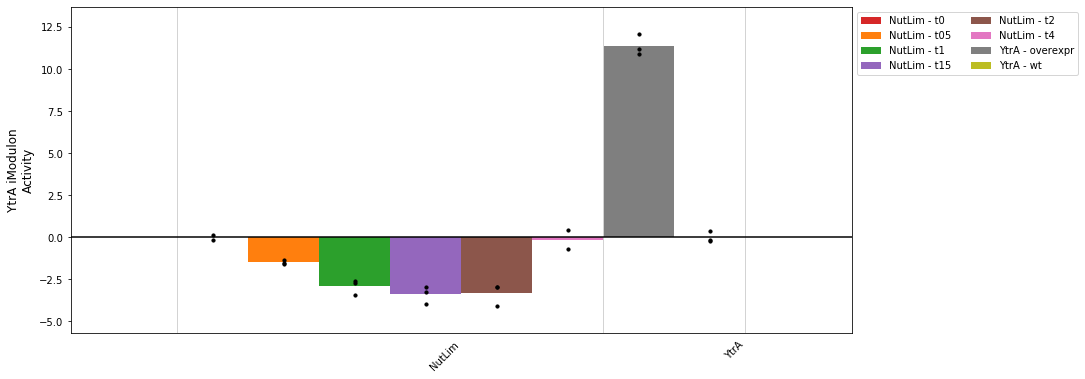

In [69]:
fig, ax = plt.subplots(figsize=(14, 6))

plot_activities(ica_data, 'YtrA',
                projects=['NutLim', 'YtrA'],
                highlight=['NutLim', 'YtrA'],
                ax=ax)

#### iModulon 13: LysM iModulon (Lysine biosynthesis)

In [70]:
get_kegg_enrichments('LysM', 'pathway')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,pathway_name
25,LysM,map01210,2.320941e-10,4.572255e-08,0.6,0.230769,0.333333,6.0,26.0,10.0,2-Oxocarboxylic acid metabolism
26,LysM,map01230,4.638471e-07,4.568894e-05,0.6,0.068966,0.123711,6.0,87.0,10.0,Biosynthesis of amino acids
27,LysM,map00290,1.283633e-05,8.429188e-04,0.3,0.250000,0.272727,3.0,12.0,10.0,"Valine, leucine and isoleucine biosynthesis"
28,LysM,map00300,2.636557e-05,1.298504e-03,0.3,0.200000,0.240000,3.0,15.0,10.0,Lysine biosynthesis
29,LysM,map01100,2.963728e-04,1.167709e-02,0.7,0.017903,0.034913,7.0,391.0,10.0,Metabolic pathways
30,LysM,map00660,6.049418e-04,1.986226e-02,0.2,0.222222,0.210526,2.0,9.0,10.0,C5-Branched dibasic acid metabolism
31,LysM,map00220,1.298557e-03,3.654511e-02,0.2,0.153846,0.173913,2.0,13.0,10.0,Arginine biosynthesis
32,LysM,map00966,4.355401e-03,9.982140e-02,0.1,1.000000,0.181818,1.0,1.0,10.0,Glucosinolate biosynthesis
33,LysM,map01110,4.560368e-03,9.982140e-02,0.4,0.023121,0.043716,4.0,173.0,10.0,Biosynthesis of secondary metabolites


In [71]:
get_kegg_enrichments('LysM', 'module')

,imodulon,kegg_id,pvalue,qvalue,precision,recall,f1score,TP,target_set_size,imodulon_size,module_name
21,LysM,M00031,6.324328e-09,0.000001,0.4,0.571429,0.470588,4.0,7.0,10.0,"Lysine biosynthesis, mediated by LysW, 2-amino..."
22,LysM,M00432,1.183116e-06,0.000067,0.3,0.500000,0.375000,3.0,6.0,10.0,"Leucine biosynthesis, 2-oxoisovalerate => 2-ox..."
23,LysM,M00763,1.183116e-06,0.000067,0.3,0.500000,0.375000,3.0,6.0,10.0,"Ornithine biosynthesis, mediated by LysW, glut..."
24,LysM,M00535,5.112088e-05,0.002173,0.2,0.666667,0.307692,2.0,3.0,10.0,"Isoleucine biosynthesis, pyruvate => 2-oxobuta..."


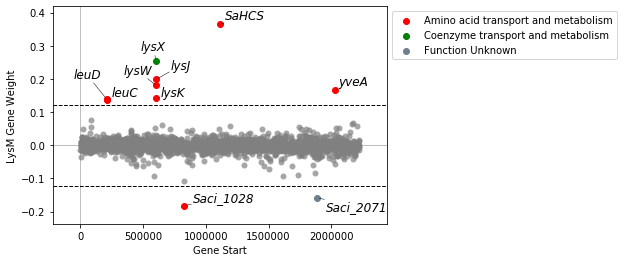

In [72]:
plot_gene_weights(ica_data, 'LysM')

In [73]:
ica_data.view_imodulon('LysM')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS01230,0.138002,leuD,Saci_0252,Sacid_00249,dmdB,211084,211569,-,3-isopropylmalate dehydratase small subunit,"2,3-dimethylmalate dehydratase small subunit",Amino acid transport and metabolism,A0A0U3H434,NC_007181.1,Op140,NaN
SACI_RS01235,0.136475,leuC,Saci_0253,Sacid_00250,NaN,211569,212813,-,3-isopropylmalate dehydratase large subunit,3-isopropylmalate dehydratase large subunit,Amino acid transport and metabolism,A0A0U3GWF6,NC_007181.1,Op140,NaN
SACI_RS03600,0.180626,lysW,Saci_0753,Sacid_00735,argW,602479,602649,+,Alpha-aminoadipate/glutamate carrier protein LysW,hypothetical protein,Amino acid transport and metabolism,A0A0U3HDS3,NC_007181.1,Op405,LysM
SACI_RS03605,0.255120,lysX,Saci_0754,Sacid_00736,lysX_1,602646,603503,+,Alpha-aminoadipate--LysW ligase LysX,Alpha-aminoadipate--LysW ligase LysX,Coenzyme transport and metabolism,A0A0U2WZV0,NC_007181.1,Op405,LysM
SACI_RS03610,0.198734,lysJ,Saci_0755,Sacid_00737,argD,603500,604663,+,[LysW]-aminoadipate semialdehyde/glutamate sem...,[LysW]-aminoadipate semialdehyde transaminase,Amino acid transport and metabolism,A0A0U2Y804,NC_007181.1,Op405,LysM
SACI_RS03615,0.141287,lysK,Saci_0756,Sacid_00738,argE,604611,605651,+,[LysW]-lysine/[LysW]-ornithine hydrolase,[LysW]-lysine hydrolase,Amino acid transport and metabolism,A0A0U3F736,NC_007181.1,Op405,LysM
SACI_RS04910,-0.182192,Saci_1028,Saci_1028,Sacid_01002,argD,827654,828943,+,acetyl ornithine aminotransferase family protein,Acetylornithine aminotransferase,Amino acid transport and metabolism,A0A0U3HA02,NC_007181.1,Op541,NaN
SACI_RS06235,0.364022,SaHCS,Saci_1304,Sacid_01280,lysS,1111101,1112507,-,homocitrate synthase,Homocitrate synthase,Amino acid transport and metabolism,UPI0000552583,NC_007181.1,Op727,NaN
SACI_RS11900,-0.158601,Saci_2071,Saci_2071,Sacid_02066,NaN,1888427,1888774,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3FPY8,NC_007181.1,Op1230,NaN
SACI_RS10580,0.166551,yveA,Saci_2189,Sacid_02188,NaN,2025549,2027396,-,APC family permease,Aspartate-proton symporter,Amino acid transport and metabolism,A0A0U3FGY1,NC_007181.1,Op1323,NaN


#### iModulon 18: UV-tfb3 iModulon (tfb3-dependent UV stress response)

- Contains ups and ced systems
- Also contains multiple genes implicated in tfb3-dependent UV stress response
- Many are uncharacterized genes, possible DNA export system found

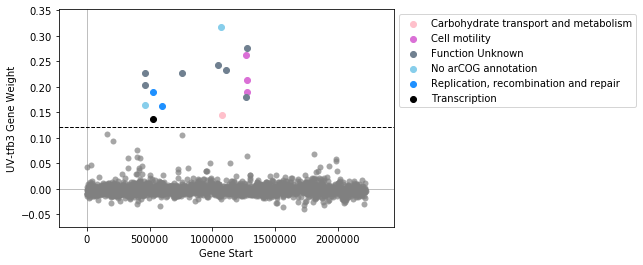

In [74]:
plot_gene_weights(ica_data, 'UV-tfb3', show_labels=False)

#plt.savefig('../figures/UV-tfb3_gene_weights.pdf', transparent=True)

In [75]:
ica_data.view_imodulon('UV-tfb3')

,gene_weight,gene_name,old_locus_tag,prokka_locus_tag,synonyms,start,end,strand,gene_product,gene_product_prokka,COG,uniprot,accession,operon,regulator
SACI_RS11810,0.164617,cedA2,Saci_0567,Sacid_00553,NaN,460159,460317,-,DNA import protein CedA2,hypothetical protein,No arCOG annotation,UPI00005522F4,NC_007181.1,Op323,tfb3
SACI_RS02695,0.226076,cedA,Saci_0568,Sacid_00554,NaN,460333,461115,-,DNA import protein CedA,hypothetical protein,Function Unknown,A0A0U3GG40,NC_007181.1,Op323,tfb3
SACI_RS02700,0.202697,cedA1,Saci_0569,Sacid_00555,NaN,461116,461352,-,DNA import protein CedA1,hypothetical protein,Function Unknown,A0A0U3GT29,NC_007181.1,Op323,tfb3
SACI_RS03170,0.135878,tfb3,Saci_0665,Sacid_00647,NaN,526865,527452,+,TFIIB-type zinc ribbon-containing protein,hypothetical protein,Transcription,A0A0U3FEZ6,NC_007181.1,Op357,tfb3
SACI_RS03180,0.190563,herA_2,Saci_0667,Sacid_00649,NaN,529180,530820,-,"HerA helicase, ATP-binding protein (VirB4/HerA...",hypothetical protein,"Replication, recombination and repair",A0A0U3GSV6,NC_007181.1,Op359,tfb3
SACI_RS03575,0.162646,cedB,Saci_0748,Sacid_00730,NaN,597891,599684,+,DNA import protein CedB (ATP-binding),hypothetical protein,"Replication, recombination and repair",A0A0U3GTT0,NC_007181.1,Op402,tfb3
SACI_RS04540,0.227926,Saci_0951,Saci_0951,Sacid_00927,NaN,760719,761144,-,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3H1M8,NC_007181.1,Op501,tfb3
SACI_RS05840,0.242446,Saci_1225,Saci_1225,Sacid_01202,NaN,1042172,1042501,+,hypothetical protein,hypothetical protein,Function Unknown,A0A0U3F641,NC_007181.1,Op680,tfb3
SACI_RS06010,0.316290,SACI_RS06010,NaN,Sacid_01236,NaN,1071231,1071434,+,hypothetical protein,hypothetical protein,No arCOG annotation,A0A0U2N8L9,NC_007181.1,Op707,NaN
SACI_RS06065,0.143969,Saci_1270,Saci_1270,Sacid_01247,NaN,1080419,1081312,+,MFS family permease,hypothetical protein,Carbohydrate transport and metabolism,A0A0U3HJZ7,NC_007181.1,Op713,tfb3


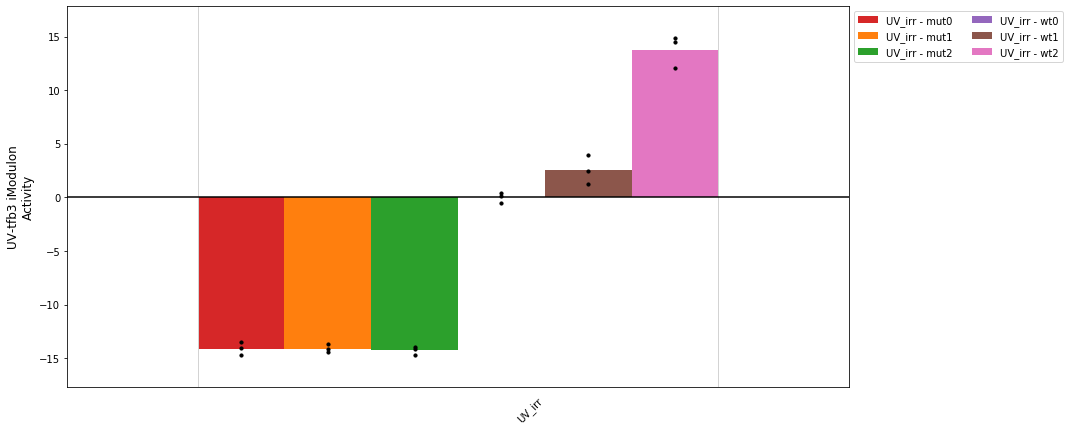

In [76]:
fig, ax = plt.subplots(figsize=(14, 7))

plot_activities(ica_data, 'UV-tfb3',projects='UV_irr', highlight='UV_irr', ax=ax)

#plt.savefig('../figures/UV-tfb3_actv.pdf')

## To be continued in next notebook